# Initialising

## Importing modules

In [70]:
%matplotlib notebook

import datetime
import numpy as np
import matplotlib as mpl
import re
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import savgol_filter
import scipy.signal as signal

import qcodes as qc
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.database import initialise_database

## Constants

In [35]:
m = 9.11e-31
h = 6.623e-34
hbar = h/(2*np.pi)
e = 1.60217662e-19
G0 = 2*e**2/h
Phi0 = h/e

## Global variables

In [36]:
where_db_files_are = r'D:/OneDrive/BF3/Data/' # change this path accordingly to the PC you are using
where_I_save_plots = r'Albertos_plots/' # relative path from current directory
g_label = '$\\dfrac{{\\mathrm{dI}}}{{\\mathrm{dV}}}$' + ' ' + '$\\left[\\dfrac{{2\\mathrm{e}^2}}{{\\mathrm{h}}}\\right]$'

# Function definitions

In [51]:
def pretty_path(experiment_date):
    return '\OneDrive\BF3\Data\experiments_' + experiment_date + '.db'

def path(where_db_files_are, experiment_date):
    return where_db_files_are + 'experiments_' + experiment_date + '.db'  

def plot_conductance_pinchoff_forth_and_back(ax, ID_forth, ID_back, reverse_g=False,
                                            gate_name='mdac_PG_voltage', conductance_name='conductance'):
    IDs = (ID_forth, ID_back)
    direction = ('forward', 'backward')
    for i in range(2):
        ID = IDs[i]
        dat = load_by_id(ID)
        gate_voltage = dat.get_data(gate_name)
        conductance = np.array(dat.get_data(conductance_name))
        if reverse_g==True:
            if np.average(conductance) < 0:
                conductance = -conductance
        label = 'RunID {}, {}'.format(ID, direction[i])
        zorder = 1-i
        ax.plot(gate_voltage, conductance, '.', label=label, zorder=zorder, markersize=5)
    ax.set(ylabel=g_label)
    return 0
        
def plot_current_pinchoff_forth_and_back(ax, ID_forth, ID_back, gate_name='mdac_PG_voltage', current_name='current'):
    IDs = (ID_forth, ID_back)
    for i in range(2):
        ID = IDs[i]
        dat = load_by_id(ID)
        gate_voltage = dat.get_data(gate_name)
        current = dat.get_data(current_name)
        direction = 'forward'
        if gate_voltage[0] > gate_voltage[-1]:
            direction = 'backward'
        label = 'RunID {}, {}'.format(ID, direction)
        zorder = 2*(1-i)
        ax.plot(gate_voltage, 1e9*np.array(current), '.', label=label, zorder=zorder, markersize=5)        
    ax.set(ylabel='Current [nA]')
    return 0

def fit_current_pinchoff_forth_and_back(ax, ID_forth, ID_back, Vbias, L, C=1e-15, Rs=13e3, Vth=0, plot=True, show_muC=True,
                                        gate_name='mdac_PG_voltage', current_name='current'):
    def pinchoff_fit_function(x, *par):
        return 1 * (x > par[2]) / (par[0] + L**2 / (par[1] * (x - par[2])))
    IDs = (ID_forth, ID_back)
    muCs = []
    Rss = []
    Vths = []
    for i in range(2):
        ID = IDs[i]
        dat = load_by_id(ID)
        gate_voltage = dat.get_data(gate_name)
        current = dat.get_data(current_name)
        try:
            p0 = [Rs, C, Vth]
            par, cov = curve_fit(pinchoff_fit_function, np.array(gate_voltage)[:,0], np.array(current)[:,0]/Vbias, p0 = p0)
            muCs.append(par[1])
            Rss.append(par[0])
            Vths.append(par[2])
            round_mu = int(np.round(np.round((par[1]/1e-15), decimals=3)*1e4))
            if plot==True:
                if show_muC == True:
                    label = '$\mu\cdot$C = {} $\\frac{{\\mathrm{{cm}}^2}}{{\\mathrm{{V\cdot s}}}}\cdot \\mathrm{{pF}}$\nR$_s$ = {:.2f} k$\Omega$\nV$_t$$_h$ = {:.3f} V'.format(round_mu, par[0]*1e-3, par[2])
                else:
                    label = 'R$_s$ = {:.2f} k$\Omega$\nV$_t$$_h$ = {:.3f} V'.format(par[0]*1e-3, par[2])
                ax.plot(gate_voltage, 1e9*pinchoff_fit_function(gate_voltage, *par)*Vbias, zorder=3-i, label=label)
        except RuntimeError:
            muCs.append(p0[1])
            Rss.append(p0[0])
            Vths.append(p0[2])
    return muCs, Rss, Vths

def fit_single_pinchoff(ax, ID, gate_voltage, current, Vbias, L, C=1e-15, Rs=13e3, Vth=0, plot=True, show_muC=True):
    def pinchoff_fit_function(x, *par):
        return 1 * (x > par[2]) / (par[0] + L**2 / (par[1] * (x - par[2])))
    try:
        p0 = [Rs, C, Vth]
        par, cov = curve_fit(pinchoff_fit_function, np.array(gate_voltage)[:,0], np.array(current)[:,0]/Vbias, p0 = p0)
        round_mu = int(np.round(np.round((par[1]/1e-15), decimals=2)*1e4))
        muC = par[1]
        Rs = par[0]
        Vth = par[2]
        if plot==True:
            if show_muC == True:
                label = '$\mu\cdot$C = {} $\\frac{{\\mathrm{{cm}}^2}}{{\\mathrm{{V\cdot s}}}}\cdot \\mathrm{{pF}}$\nR$_s$ = {:.1f} k$\Omega$\nV$_t$$_h$ = {:.2f} V'.format(round_mu, par[0]*1e-3, par[2])
            else:
                label = 'R$_s$ = {:.1f} k$\Omega$\nV$_t$$_h$ = {:.2f} V'.format(par[0]*1e-3, par[2])
                
            ax.plot(gate_voltage, 1e9*pinchoff_fit_function(gate_voltage, *par)*Vbias, label=label)
    except RuntimeError:
        muC = p0[1]
        Rs = p0[0]
        Vth = p0[2]
    return muC, Rs, Vth

def times_forth_and_back(ID_forth, ID_back):
    datforth = load_by_id(ID_forth)
    datback = load_by_id(ID_back)
    t1 = datforth.completed_timestamp_raw - datforth.run_timestamp_raw
    t2 = datback.run_timestamp_raw - datforth.completed_timestamp_raw
    t3 = datback.completed_timestamp_raw - datback.run_timestamp_raw
    ts = [int(t1), int(t2), int(t3)]
    deltat = int(datback.run_timestamp_raw - datforth.run_timestamp_raw)
    return deltat, ts

def device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name):
    try:
        device = re.search('(.+?)_', sample_name).group(1)
        source_letter = re.search('_(.+?)', sample_name).group(1)
        source_number = re.search('_' + source_letter + '([0-9]+)', sample_name).group(1)
        drain_letter = re.search('_' + source_letter + source_number + '(.+?)', sample_name).group(1)
        drain_number = re.search('_' + source_letter + source_number + drain_letter + '([0-9]+)', sample_name).group(1)
        source = source_letter + source_number
        drain = drain_letter + drain_number
        return device, source, drain
    except AttributeError:
        return sample_name, '?', '?'
    
def plot_pinchoff(IDs, biases, where_I_save, save=True, fit=True, L=3e-6, C=1e-15, Vth=0, reverse_g=False,
                  show_L=True, show_muC=True,
                  gate_name='mdac_PG_voltage', current_name='current', g_name='conductance', tag=''):
    if len(IDs) != len(biases):
        print('Warning: first and second argument must have the same length')
    else:
        N = len(IDs)
        
    data = []
    sources = []
    drains = []
    sample_name = ''
    for i in range(N):
        dat = load_by_id(IDs[i])
        sample_name = dat.sample_name
        device, source, drain = device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name)
        data.append(dat)
        sources.append(source)
        drains.append(drain)
    
    n_subplots = int(np.ceil(N/2))
    figsize = (6, 1 + 2.5*n_subplots)
    figname = sample_name + tag
    fig, axes = plt.subplots(ncols=1, nrows=n_subplots, sharex=True, figsize=figsize, num=figname)
    fig.set_tight_layout(True)
    
    try:
        n_axes = len(axes)
    except TypeError:
        axes = [axes]
    axes[0].set(title=pretty_path(experiment_date))
    axes[-1].set(xlabel='Gate [V]')
    for i, ax in enumerate(axes):
        #puts two measurements per figure, IDs have to be in the right order
        if biases[2*i] != biases[2*i + 1]:
            print('Warning')
        else:
            if biases[2*i] > 0:
                plot_current_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], gate_name=gate_name, current_name=current_name)
                if fit==True:
                    if isinstance(L, (list, tuple, np.ndarray)):
                        length=L[i]
                    else:
                        length=L
                    muCs, Rss, Vths = fit_current_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], biases[2*i], L=length, C=C, Vth=Vth, gate_name=gate_name, current_name=current_name, show_muC=show_muC)
                    print('data format = [forward, backward]')
                    print('mu*C =', list((np.round(np.array(muCs)*1e18)*1e1).astype(int)), '(cm^2 / (V*s)) * pF')
                    print('Rs =', list(np.round(np.array(Rss)*1e-3,decimals=2)), 'kOhm')
                    print('Vth =', list(np.round(np.array(Vths),decimals=3)), 'V')
                    print('delta Vth =', int((Vths[1]-Vths[0])*1e3), 'mV')
                    delta_t, ts = times_forth_and_back(IDs[2*i], IDs[2*i+1])
                    print('delta t between gate sweeps =', delta_t, 's')
                    print('[forward, delay, backward] times:', ts, 's\n')
            else:
                plot_conductance_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], reverse_g=reverse_g, gate_name=gate_name, conductance_name=g_name)
        ax.grid(linestyle=':')
        ax.legend(loc=4)
    for i, ax in enumerate(axes):
        left, right = ax.get_xlim()
        bottom, top = ax.get_ylim()
        y = top - 0.05*(top - bottom)
        x = left + 0.023*(right - left)
        box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)
        if show_L==True:
            if isinstance(L, (list, tuple, np.ndarray)):
                length=L[i]
            else:
                length=L
            if sources[2*i] != drains[2*i]:
                box_text = 'Source: {}\nDrain: {}\nL = {} $\mu$m\nBias = {} mV'.format(sources[2*i], drains[2*i], np.round(length*1e6, decimals=2), int(biases[2*i]*1e3))
            else:
                box_text = 'L = {} $\mu$m\nBias = {} mV'.format(np.round(length*1e6, decimals=2), int(biases[2*i]*1e3))
                
        else:
            if sources[2*i] != drains[2*i]:
                box_text = 'Source: {}\nDrain: {}\nBias = {} mV'.format(sources[2*i], drains[2*i], int(biases[2*i]*1e3))
            else:
                box_text = 'Bias = {} mV'.format(int(biases[2*i]*1e3))
        ax.text(x, y, box_text, horizontalalignment='left', verticalalignment='top', bbox=box_props)
    
    if save==False:
        return 0
    else:
        RunIDs = '_RunIDs'
        for i in range(N):
            RunIDs = RunIDs + '-' + str(IDs[i])
        name = where_I_save + experiment_date + RunIDs + tag
        plt.savefig(name, dpi=300)
        return 0
    
def plot_g_pinchoff(ID, gate, g, xlabel='Gate [V]', ylabel=g_label, set_ylim=False):
    if gate[0] < gate[-1]:
        direction = 'forward'
    elif gate[0] > gate[-1]:
        direction = 'backward'
    else:
        cut = int(len(gate)/2)
        plot_g_pinchoff(ID, gate[:cut], g[:cut], xlabel='Gate [V]', ylabel=g_label, set_ylim=set_ylim)
        plot_g_pinchoff(ID, gate[cut:], g[cut:], xlabel='Gate [V]', ylabel=g_label, set_ylim=set_ylim)
    label = 'RunID {}, {}'.format(ID, direction)
    bottom, top = plt.ylim()
    plt.plot(gate, g, '.', label=label, markersize=5)
    if set_ylim==True:
        if direction == 'forward':
            top = np.average(g[-5:])*1.1
            bottom = -np.average(g[-5:])*0.1
        else:
            top = np.average(g[:5])*1.1
            bottom = -np.average(g[:5])*0.1
        plt.ylim(bottom, top)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle=':')
    plt.legend()
    return top

def plot_single_pinchoff(ID, gate, current, bias, where_I_save, save=True, fit=True, L=3e-6, C=1e-15, 
                         reverse_g=False, show_L=True):
    dat = load_by_id(ID)
    sample_name = dat.sample_name
    device, source, drain = device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name)

    figsize = (6, 4)
    figname = sample_name + '_RunID'+ str(ID)
    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=figsize, num=figname)
    fig.set_tight_layout(True)
    ax.set(title=pretty_path(experiment_date))
    ax.set(xlabel='Gate [V]')
    if gate[0] < gate[1]:
        label='RunID {}, forward'.format(ID)
    else:
        label='RunID {}, backward'.format(ID)
    ax.plot(gate, 1e9*np.array(current), '.', label=label, markersize=5)
    if fit==True:
        muC, Rs, Vth = fit_single_pinchoff(ax, ID, gate, current, bias, L)
        print('mu*C =', (np.round(muC*1e17)*1e2).astype(int), '(cm^2 / (V*s)) * pF')
        print('Rs =', np.round(Rs*1e-3,decimals=1), 'kOhm')
        print('Vth =', np.round(Vth,decimals=3), 'V')
    ax.grid(linestyle=':')
    ax.legend(loc=4)

    left, right = ax.get_xlim()
    bottom, top = ax.get_ylim()
    y = top - 0.05*(top - bottom)
    x = left + 0.023*(right - left)
    box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)
    length=L
    box_text = 'Source: {}\nDrain: {}\nL = {} $\mu$m\nBias = {} mV'.format(source, drain, np.round(length*1e6, decimals=2), int(bias*1e3))
    ax.text(x, y, box_text, horizontalalignment='left', verticalalignment='top', bbox=box_props)
    
    if save==False:
        return 0
    else:
        name = where_I_save + experiment_date + '_RunID' + str(ID)
        plt.savefig(name, dpi=300)
        return 0    
    
def unpack_2D_sweep(slow_sweep, fast_sweep, z):
    slow_sweep = np.array(slow_sweep)
    fast_sweep = np.array(fast_sweep)
    z = np.array(z)
    x = np.unique(slow_sweep.round(decimals=12))
    if x[0] > x[-1]:
        x = x[::-1]
    y = np.unique(fast_sweep.round(decimals=12))
    if y[0] > y[-1]:
        y = y[::-1]
    zz = np.reshape(z, (len(x), len(y)))
    return x, y, zz

# pinch-off (plot + fit)

In [22]:
experiment_date = '2019-06-23'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

<IPython.core.display.Javascript object>


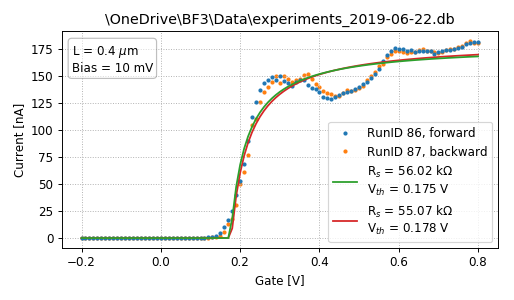

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [710, 650] (cm^2 / (V*s)) * pF
Rs = [56.020000000000003, 55.07] kOhm
Vth = [0.17499999999999999, 0.17799999999999999] V
delta Vth = 2 mV
delta t between gate sweeps = 223 s
[forward, delay, backward] times: [222, 1, 263] s



In [19]:
IDs = [86,87]
biases = np.array([10,10])*1e-3 #V
L = 0.4e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, C=1e-17, Vth=0.1, show_muC=False, gate_name='mdac_TG2_voltage', current_name='current')

# I bias supercurrent

In [38]:
experiment_date = '2019-06-24'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

In [52]:
RunID = 15
dat = load_by_id(RunID)

gate = dat.get_data('mdac_CUT_voltage')
bias = dat.get_data('mdac_Bias_voltage')
voltage = dat.get_data('Voltage')

x,y,z = unpack_2D_sweep(gate, bias, voltage)

<IPython.core.display.Javascript object>


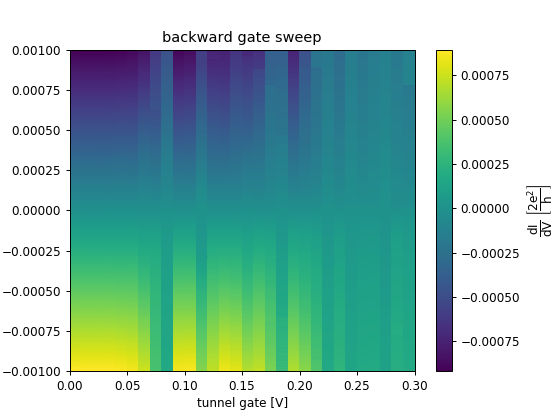

Text(0,0.5,'$\\dfrac{{\\mathrm{dI}}}{{\\mathrm{dV}}}$ $\\left[\\dfrac{{2\\mathrm{e}^2}}{{\\mathrm{h}}}\\right]$')

In [57]:
m = np.max(z[:, 0])
vmax = 1.05*m

cmap = plt.cm.viridis #viridis it's the default
norm = mpl.colors.Normalize()

fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True)
cmap = plt.cm.viridis #viridis it's the default
norm = mpl.colors.Normalize()
yy = y[::-1]
cut=0
im = axes.pcolor(x, yy, z.T, cmap=cmap, norm=norm)
axes.set(xlabel='tunnel gate [V]', ylabel='Bias [uA]', title='backward gate sweep')

cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel(g_label)

In [74]:
kern = np.ones((11, 1))
z_smooth = signal.convolve(z, kern)

dz = np.diff(z)
R = 1/dz - 18.4

<IPython.core.display.Javascript object>


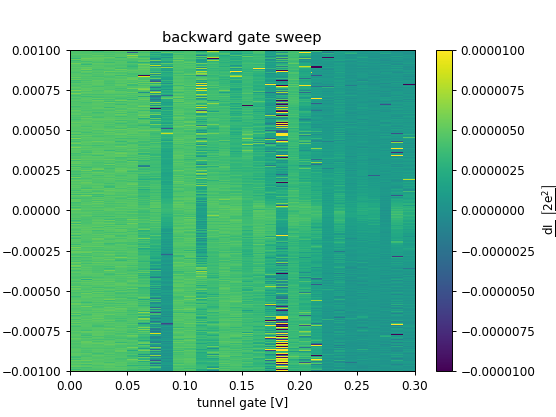

Text(0,0.5,'$\\dfrac{{\\mathrm{dI}}}{{\\mathrm{dV}}}$ $\\left[\\dfrac{{2\\mathrm{e}^2}}{{\\mathrm{h}}}\\right]$')

In [78]:
fig2, axes = plt.subplots(ncols=1, nrows=1, sharey=True)
cmap = plt.cm.viridis #viridis it's the default
norm = mpl.colors.Normalize(-1e-5,1e-5)
yy = y[::-1]
im = axes.pcolor(x, yy, dz.T, cmap=cmap, norm=norm)
axes.set(xlabel='tunnel gate [V]', ylabel='Bias [uA]', title='backward gate sweep')

cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel(g_label)